In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
url="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2" \
    "Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [4]:
countries = {"Russia", "Italy", "Japan", "Spain", "Germany", "Korea, South", "Brazil", "Iran", "US", "Singapore"}

In [5]:
df[df["Country/Region"].isin(countries)]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
28,NaN,Brazil,-14.2350,-51.9253,0,0,0,0,0,0,...,1021,1546,1924,2247,2554,2985,3417,3904,4256,4579
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,22213,24873,29056,32986,37323,43938,50871,57695,62095,66885
133,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,20610,21638,23049,24811,27017,29406,32332,35408,38309,41495
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,53578,59138,63927,69176,74386,80589,86498,92472,97689,101739
139,NaN,Japan,36.0000,138.0000,2,2,2,2,4,4,...,1007,1101,1128,1193,1307,1387,1468,1693,1866,1866
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,8799,8961,8961,9037,9137,9241,9332,9478,9583,9661
187,NaN,Russia,60.0000,90.0000,0,0,0,0,0,0,...,306,367,438,495,658,840,1036,1264,1534,1836
196,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,432,455,509,558,631,683,732,802,844,879
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,25374,28768,35136,39885,49515,57786,65719,73235,80110,87956
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,25489,33276,43847,53740,65778,83836,101657,121478,140886,161807


In [6]:
confirmed = dict()
for country in countries:
    cdf = df[(df["Country/Region"]==country) & (df["Province/State"].isnull())][df.columns[4:-1]].T
    if len(cdf.columns) > 0:
        confirmed[country] = np.array(cdf[cdf.columns[0]])

In [7]:
cdf = df[(df["Province/State"]=="Hubei")][df.columns[4:-1]].T
confirmed["Hubei"] = np.array(cdf[cdf.columns[0]])

In [8]:
import matplotlib.pyplot as plt

In [9]:
def exp_smoothing(lst, alpha=0.1):
    tmp_ = lst[0]
    result = [tmp_]
    for x in lst[1:]:
        tmp_ =  x * (1 - alpha) + alpha * tmp_
        result.append(tmp_)
    return result

In [10]:
def division_smoothed(lst):
    result = []
    for prev, cur in zip(lst[:-1], lst[1:]):
        if prev < 1.0:
            result.append(1.0)
        else:
            result.append(cur / prev)
    return result

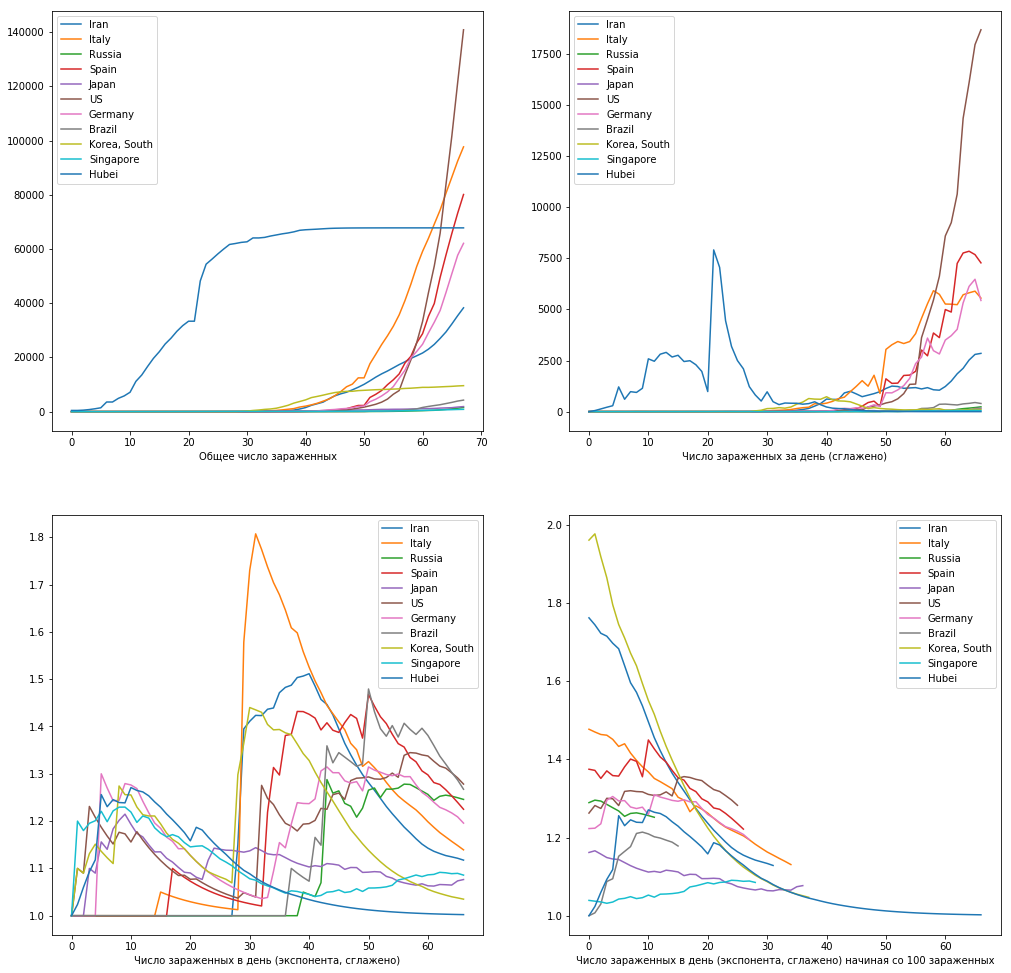

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(17, 17))
ax[0, 0].set_xlabel("Общее число зараженных")
for country, cases in confirmed.items():
    ax[0, 0].plot(range(0, len(cases)), cases, label=country)
ax[0, 0].legend()

ax[0, 1].set_xlabel("Число зараженных за день (cглажено)")
for country, cases in confirmed.items():
    ax[0, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] - cases[:-1], alpha=0.5), label=country)
ax[0, 1].legend()

ax[1, 0].set_xlabel("Число зараженных в день (экспонента, сглажено)")
for country, cases in confirmed.items():
    ax[1, 0].plot(range(0, len(cases) - 1), exp_smoothing(division_smoothed(cases), alpha=0.9), label=country)
ax[1, 0].legend()

ax[1, 1].set_xlabel("Число зараженных в день (экспонента, сглажено) начиная со 100 зараженных")
for country, cases in confirmed.items():
    cases = cases[cases.searchsorted(100):]
    ax[1, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] / (cases[:-1]), alpha=0.9), label=country)
ax[1, 1].legend()

fig.savefig("covid19.png")
plt.show()